(50000, 32, 32, 3)
(50000, 1)
Epoch 1/2
500/500 [==============================] - 54s 108ms/step - loss: 2.0853 - sparse_categorical_accuracy: 0.2168
Epoch 2/2
500/500 [==============================] - 54s 108ms/step - loss: 1.7638 - sparse_categorical_accuracy: 0.3505
Variance PCA: 1.0
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.264s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.044950
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.494370
[t-SNE] KL divergence after 1000 iterations: 1.104519


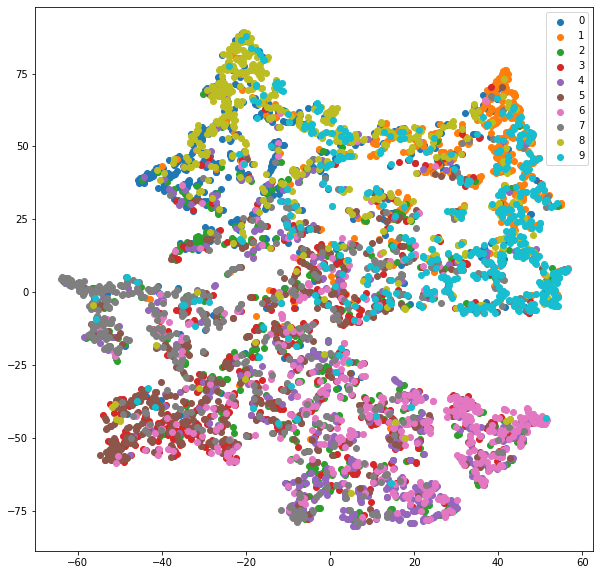

In [4]:
# -*- coding: utf-8 -*-
"""
Visualizing the hidden Layer in Neural Networks @ CIFAR10 dataset
Created on Sat Dec 28 19:49:26 2019
@author: liujie
# Credit:
# Visualizing Layer Representations in Neural Networks
# https://becominghuman.ai/visualizing-representations-bd9b62447e38
"""

from __future__ import print_function
import numpy as np

from keras.utils import np_utils
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt


#-----------------------------模型超参数------------------------------
num_epochs = 2
batch_size = 100
learning_rate = 0.01

#-----------------------------数据获取及预处理------------------------------
#tf.keras.datasets
class CIFARLoader():
    def __init__(self):
        cifar = tf.keras.datasets.cifar10
        (self.train_data, self.train_label), (self.test_data, self.test_label) = cifar.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        self.train_data = self.train_data.astype(np.float32) / 255.0      # [60000, 28, 28, 1]
        self.test_data = self.test_data.astype(np.float32) / 255.0        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, np.shape(self.train_data)[0], batch_size)
        return self.train_data[index, :], self.train_label[index]

# 测试CIFARLoader()
data_loader = CIFARLoader()
print(data_loader.train_data.shape)
print(data_loader.train_label.shape)




#-----------------------------模型的构建------------------------------
#Keras Functional API 模式建立模型
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dense(units=10)(x)
outputs = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

'''
#-----------------------------模型构建的第2种写法------------------------------
#Keras Sequential API 模式建立模型
from tensorflow.keras import layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)
'''

#-----------------------------数据读取和Fit模型------------------------------
data_loader = CIFARLoader()
model.fit(data_loader.train_data, data_loader.train_label, epochs=num_epochs, batch_size=batch_size)

#-------------------------------获取模型最后一层的数据--------------------------------
# 获取x = tf.keras.layers.Flatten()(x)数据
# Reference:https://becominghuman.ai/visualizing-representations-bd9b62447e38
def create_truncated_model(trained_model):
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

truncated_model = create_truncated_model(model)
hidden_features = truncated_model.predict(data_loader.train_data)

#-------------------------------PCA,tSNE降维分析--------------------------------
pca = PCA(n_components=9)# 总的类别
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

#-------------------------------可视化--------------------------------

y_test_cat = np_utils.to_categorical(data_loader.train_label[:5000], num_classes = 10)# 总的类别
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(10):# 总的类别
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()

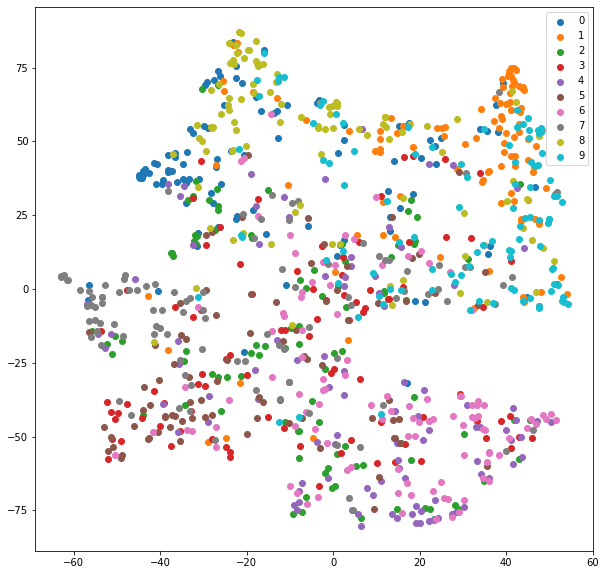

In [6]:
from keras.utils import np_utils
y_test_cat = np_utils.to_categorical(data_loader.train_label[:1000], num_classes = 10)# 总的类别
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(10):# 总的类别
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()